In [1]:
!python --version

Python 3.10.5


In [2]:
#Preprocessing code borrowed from Fabrizio Ravelli: https://www.kaggle.com/code/fabrizioravelli/alzheimer-s-disease-classification-98-acc

import os
import cv2
import random
from tqdm import tqdm
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras.backend as K

from keras import models
from keras import layers
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Model



CLASSES = ("MILD_DEMENTED", "NON_DEMENTED", "VERYMILD_DEMENTED")
DATASET_DIR = "data/"
TEST_DIR = DATASET_DIR + "test/"
TRAINING_DIR = DATASET_DIR + "train/"

IMG_SIZE = 100

def create_data(directory):
    data = []
    for CLASSE in CLASSES:
        path = os.path.join(directory, CLASSE)
        class_num = CLASSES.index(CLASSE)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append((img_array, class_num))
            
    return data

train_data = create_data(TRAINING_DIR)
test_data = create_data(TEST_DIR)

random.shuffle(train_data)
random.shuffle(test_data)

def prepare_data(data):
    inp = []
    out = []
    
    for img, label in data:
        inp.append(img)
        y = np.zeros(len(CLASSES))
        y[label] = 1
        out.append(y)
    inp = np.array(inp).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    
    return inp, out

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

X_train = X_train / 255
y_train = np.array(y_train)

X_test = X_test / 255
y_test = np.array(y_test)

for classe in CLASSES:
    class_num = CLASSES.index(classe)
    print(classe, class_num)


100%|█████████████████| 224/224 [00:00<00:00, 781.07it/s]


MILD_DEMENTED 0
NON_DEMENTED 1
VERYMILD_DEMENTED 2


Text(0.5, 0, 'Mild Demented')

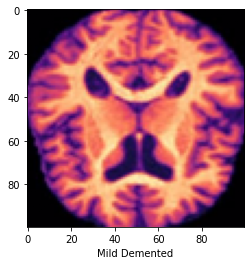

In [3]:
plt.imshow(X_train[6:7][0,:,:,:])
plt.xlabel("Mild Demented")

Text(0.5, 0, 'Very Mild Demented')

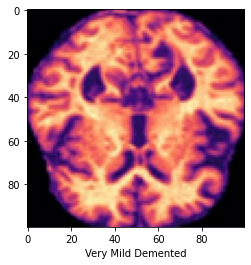

In [4]:
plt.imshow(X_train[37:38][0,:,:,:])
plt.xlabel("Very Mild Demented")

Text(0.5, 0, 'Non Demented')

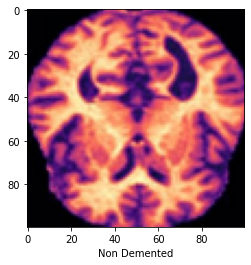

In [5]:
plt.imshow(X_train[65:66][0,:,:,:])
plt.xlabel("Non Demented")

In [29]:
input_shape = X_train.shape[1:]

inputs = layers.Input(shape=input_shape)
x1 = layers.Conv2D(32, (3, 3), 
                   activation='relu', 
                   input_shape=input_shape)(inputs)
x1 = layers.AveragePooling2D((2, 2))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(64, (3, 3), 
                   activation='relu', 
                   input_shape=input_shape)(x1)
x1 = layers.AveragePooling2D((2, 2))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(128, (3, 3), 
                   activation='relu', 
                   input_shape=input_shape)(x1)
x1 = layers.AveragePooling2D((2, 2))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(256, (3, 3), 
                   activation='relu', 
                   input_shape=input_shape)(x1)
x1 = layers.AveragePooling2D((2, 2))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(512, (3, 3), 
                   activation='relu', 
                   input_shape=input_shape)(x1)
x1 = layers.AveragePooling2D((2, 2))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dropout(0.5)(x1)

x2 = layers.Conv2D(128, (5, 5), 
                   activation='relu', 
                   input_shape=input_shape)(inputs)
x2 = layers.AveragePooling2D((3, 3))(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(256, (5, 5), 
                   activation='relu', 
                   input_shape=input_shape)(x2)
x2 = layers.AveragePooling2D((3, 3))(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(512, (5, 5), 
                   activation='relu', 
                   input_shape=input_shape)(x2)
x2 = layers.AveragePooling2D((3, 3))(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dropout(0.5)(x2)

x3 = layers.Conv2D(128, (7, 7), 
                   activation='relu', 
                   input_shape=input_shape)(inputs)
x3 = layers.AveragePooling2D((5, 5))(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2D(256, (7, 7), 
                   activation='relu', 
                   input_shape=input_shape)(x3)
x3 = layers.AveragePooling2D((5, 5))(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Flatten()(x3)
x3 = layers.Dropout(0.5)(x3)

x = layers.concatenate([x1,x2,x3])
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs, name = "modelv3")

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

model.summary()

Model: "modelv3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_64 (Conv2D)             (None, 98, 98, 32)   896         ['input_8[0][0]']                
                                                                                                  
 average_pooling2d_62 (AverageP  (None, 49, 49, 32)  0           ['conv2d_64[0][0]']              
 ooling2D)                                                                                        
                                                                                            

In [30]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.01)

Epoch 1/100
177/177 [==============================] - 11s 53ms/step - loss: 1.0715 - acc: 0.5824 - prec: 0.5859 - rec: 0.5674 - auc: 0.7940 - val_loss: 1.4560 - val_acc: 0.5263 - val_prec: 0.5263 - val_rec: 0.5263 - val_auc: 0.7297
Epoch 2/100
177/177 [==============================] - 9s 49ms/step - loss: 0.7197 - acc: 0.6183 - prec: 0.6278 - rec: 0.5984 - auc: 0.8391 - val_loss: 1.0209 - val_acc: 0.5614 - val_prec: 0.5918 - val_rec: 0.5088 - val_auc: 0.7673
Epoch 3/100
177/177 [==============================] - 9s 49ms/step - loss: 0.6706 - acc: 0.6339 - prec: 0.6451 - rec: 0.6137 - auc: 0.8515 - val_loss: 0.6289 - val_acc: 0.6140 - val_prec: 0.6154 - val_rec: 0.5614 - val_auc: 0.8566
Epoch 4/100
177/177 [==============================] - 9s 49ms/step - loss: 0.6300 - acc: 0.6543 - prec: 0.6681 - rec: 0.6317 - auc: 0.8655 - val_loss: 0.6049 - val_acc: 0.6316 - val_prec: 0.6863 - val_rec: 0.6140 - val_auc: 0.8688
Epoch 5/100
177/177 [==============================] - 9s 49ms/step - l

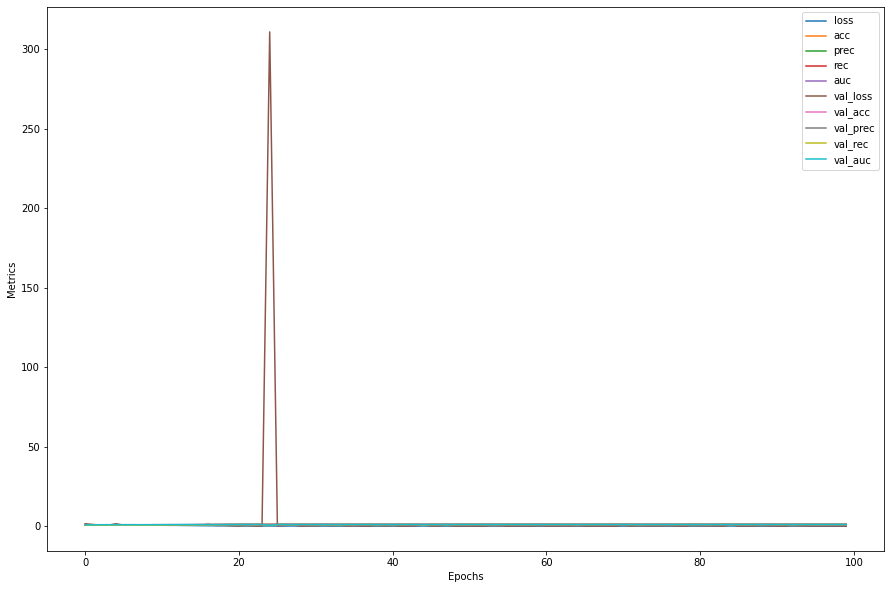

In [31]:
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()

In [32]:
test_scores = model.evaluate(X_test, y_test)

print("Testing Loss: %.2f%%"%(test_scores[0] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print("Testing Precision: %.2f%%"%(test_scores[2] * 100))
print("Testing Recall: %.2f%%"%(test_scores[3] * 100))
print("Testing AUC: %.2f%%"%(test_scores[4] * 100))

20/20 [==============================] - 0s 14ms/step - loss: 0.0421 - acc: 0.9905 - prec: 0.9905 - rec: 0.9905 - auc: 0.9975
Testing Loss: 4.21%
Testing Accuracy: 99.05%
Testing Precision: 99.05%
Testing Recall: 99.05%
Testing AUC: 99.75%


In [33]:
model.save('movelv11_100epochs')

INFO:tensorflow:Assets written to: movelv11_100epochs/assets


INFO:tensorflow:Assets written to: movelv11_100epochs/assets


In [34]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

cm=confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))

20/20 [==============================] - 1s 17ms/step


In [42]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         0.984375   0.015625  ]
 [0.         0.00446429 0.99553571]]


NameError: name 'itertools' is not defined

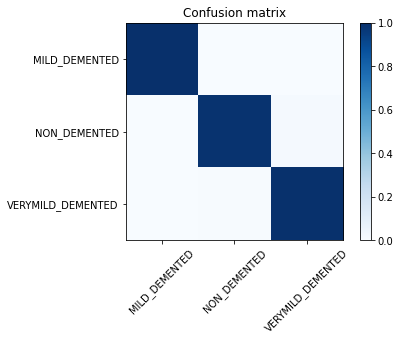

In [47]:
plot_confusion_matrix(cm, CLASSES, normalize=True)